In [ ]:
# hashtags: python, matplotlib, pandas, sport analytics, soccer, understat

# in retrospective:
    """the for loops ('...for player in players') applied to the pandas dataframes, although they make
    the code more readable, are very inefficient! Some of them take minutes!
    I would rewrite those parts using groupby(['player_id']), and applying transformations to these
    group dataframes, which would be exponentially faster.
        
        it would have been interesting to have plotted other statistics such as:
    # xGs-per-shot vs shots (it would show the type of shots each player is taking, and combined with
    the number of shots it will show the relationship bw volume and efficiency)
    # GAAs vs shots (it would show how the players perform in relation with the average player (xGs)).
    
        finally interactive plots you can hover onto and explore the different outliers and interesting
    points of the scatterplots would have been a great addition, but this was hard to do with
    matplotlib.    
    """
# credits:
    """This notebook tries to replicate and expand on the interesting analysis and data visualizations
    of Benjamin Morris' articles."""


In [1]:
from IPython.core.display import display, HTML

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<div style="text-align:right">
    <a href="javascript:code_toggle()">show/hide</a> raw code
</div> 
''')

# Player Comparison

In [1]:
## imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
## loading data and filtering Russian league info out
russia = ["Lokomotiv Moscow","CSKA Moscow","Spartak Moscow","FC Krasnodar","Zenit St. Petersburg","FC Ufa","Arsenal Tula","Dinamo Moscow","FK Akhmat","Rubin Kazan","FC Rostov","Ural",
            "Amkar","Anzhi Makhachkala","Tosno","SKA-Khabarovsk","Krylya Sovetov Samara","FC Orenburg","Tom Tomsk","Mordovya","Kuban Krasnodar","Torpedo Moscow",]
allshots = pd.read_csv("allshots.csv")
allshots = allshots[~allshots.h_team.isin(russia)]

## defining field dimensions
field_width = 75 # standard international soccer field 115(l) x 75(w) yards
field_length = 104.347826 # penalty spot at 0.885 in understat, thus 12/0.115=104.347826
"""
## defining location coordinates (used in Long-Range Shots plot)
in the dataset length, width values (X, Y features respectively) are given as a percentage of that field dimension
we will convert them to (x, y) points in a half field representation with the goal in the upper side with:
    x = field_width - shots.Y*field_width 
    y = shots.X*field_length
"""

## players info (name, games, games_season, teams)
allinfo = pd.read_csv("allinfo.csv")
players_ids = list(set(allinfo.player_id))
games = {}
games_season = {}
name = {}
names = [] # to help in search process
teams = {}
for player_id in players_ids :
    # name
    player_name = allinfo[allinfo.player_id==player_id].player.tolist()[0]
    name[player_id] = player_name
    names.append(player_name)
    # games
    season_rows = allinfo[(allinfo.player_id==player_id)&~(allinfo.Team.isin(russia))]
    player_games = sum(season_rows.Apps)
    games[player_id] = player_games
    games_season[player_id] = {int(season.split("/")[0]):sum(season_rows[season_rows.Season==season].Apps.tolist()) for season in ["2014/2015","2015/2016","2016/2017","2017/2018"]}    
    # teams
    seasons_list_pre = season_rows.Season.tolist()
    seasons_list = [int(season.split("/")[0]) for season in seasons_list_pre]
    teams_list = season_rows.Team.tolist()
    if any (seasons_list.count(year)>1 for year in seasons_list) :
        indexes = list(set([seasons_list.index(year) for year in seasons_list if seasons_list.count(year)==2]))
        z = -1
        for index in indexes :
            z += 1
            index -= z # adjusting index since we have shortened the original list
            seasons_list.remove(seasons_list[index])
            doubleteam = [teams_list[index],teams_list[index+1]]
            teams_list.remove(teams_list[index])
            teams_list[index] = doubleteam
    teams[player_id] = dict(list(zip(seasons_list,teams_list)))

In [7]:
## filtering shots & players, defining variables for the different plots

### OVERALL PRODUCTION ###
shots1 = allshots[(allshots.result=="Goal")]
players1 = list(set(shots1.player_id))
x1 = [games[player] for player in players1] 
y1 = [(len(shots1[(shots1.player_id==player)]) + len(shots1[(shots1.player_assisted==name[player])])) for player in players1]

### OVERALL PRODUCTION BY SEASON ###
shots2 = allshots[(allshots.result=="Goal")]
players2 = [player for player in players1 if (games[player]>=50 
            and games_season[player][2014]>=15 and games_season[player][2015]>=15 
            and games_season[player][2016]>=15 and games_season[player][2017]>=15)]
#x2, y2 defined at plotting

### ASSISTS VS GOALS ###
shots3 = allshots[(allshots.result=="Goal")]
players3 = [player for player in players1 if games[player]>=100]
x3 = [len(shots3[(shots3.player_id==player)])/games[player] for player in players3]
y3 = [len(shots3[(shots3.player_assisted==name[player])])/games[player] for player in players3]

### SHOOTING EFFICIENCY VS SHOOTING VOLUME ###
shots4 = allshots[(allshots.situation=="OpenPlay")&~(allshots.result=="OwnGoal")]
players4 = list(set(shots4.player_id))
players4 = [player for player in players4 if games[player]>=50]
x4 = [len(shots4[shots4.player_id==player])/games[player] for player in players4]
y4 = [len(shots4[(shots4.player_id==player)&(shots4.result=="Goal")])*100/len(shots4[shots4.player_id==player]) for player in players4] 
players4_2 = [c for a,b,c in zip(x4,y4,players4) if a>1 and b>0]
x4_2 = [a for a,b in zip(x4,y4) if a>1 and b>0]
y4_2 = [b for a,b in zip(x4,y4) if a>1 and b>0]
x4,y4,players4 = x4_2,y4_2,players4_2

### SHOOTING EFFICIENCY WHEN ASSISTED/UNASSISTED ###
shots5 = allshots[(allshots.situation=="OpenPlay")&~(allshots.result=="OwnGoal")]
players5 = list(set(shots5.player_id))
z1 = [len(shots5[(shots5.player_id==player)&(shots5.player_assisted.notnull())]) for player in players5]
z2 = [len(shots5[(shots5.player_id==player)&(shots5.player_assisted.isnull())]) for player in players5]
#players5 = [a for a,b,c in zip(players5,z1,z2) if b>=50 and c>=50] # 23 players
players5 = [a for a,b,c in zip(players5,z1,z2) if b>=25 and c>=25] # 208 players
x5 = [len(shots5[(shots5.player_id==player)&(shots5.result=="Goal")&(shots5.player_assisted.notnull())])*100
    /len(shots5[(shots5.player_id==player)&(shots5.player_assisted.notnull())]) for player in players5]
y5 = [len(shots5[(shots5.player_id==player)&(shots5.result=="Goal")&(shots5.player_assisted.isnull())])*100
    /len(shots5[(shots5.player_id==player)&(shots5.player_assisted.isnull())]) for player in players5]

### IN-PLAY LONG-RANGE SHOTS ###
shots6 = allshots[(allshots.situation=="OpenPlay")&~(allshots.result=="OwnGoal")]
x = field_width - shots6.Y*field_width
y = shots6.X*field_length
shots6 = shots6[
    ((x>=0)&(x<=field_width)&(y<=field_length)&(y>=field_length/2)) # within half field
    &~((x>=(field_width-44)/2)&(x<=field_width-(field_width-44)/2)&(y<=field_length)&(y>=field_length-18))] # out of the penalty area
players6 = list(set(shots6.player_id))
x6 = [len(shots6[shots6.player_id==player]) for player in players6]
y6 = [len(shots6[(shots6.result=="Goal")&(shots6.player_id==player)]) for player in players6]

### FREE KICKS ###
shots7 = allshots[(allshots.situation=="DirectFreekick")]
players7 = list(set(shots7.player_id))
x7 = [len(shots7[shots7.player_id==player]) for player in players7]
y7 = [len(shots7[(shots7.result=="Goal")&(shots7.player_id==player)]) for player in players7]

### SET-PIECE HEADERS ###
shots8 = allshots[((allshots.situation=="FromCorner")|(allshots.situation=="SetPiece"))&(allshots.shotType=="Head")]
players8 = list(set(shots8.player_id))
x8 = [len(shots8[shots8.player_id==player]) for player in players8]
y8 = [len(shots8[(shots8.result=="Goal")&(shots8.player_id==player)]) for player in players8]

### PENALTY KICKS ###
shots9 = allshots[(allshots.situation=="Penalty")]
players9 = list(set(shots9.player_id))
x9 = [len(shots9[shots9.player_id==player]) for player in players9]
y9 = [len(shots9[(shots9.result=="Goal")&(shots9.player_id==player)]) for player in players9]

### STATS ###
shots10 = allshots[~(allshots.result=="OwnGoal")]
players10 = list(set(shots10.player_id))

Player1: Lionel Messi
player found: Lionel Messi (Barcelona)
Enter to confirm / Write another name to change :

Player2: Cristiano Ronaldo
player found: Cristiano Ronaldo (Real Madrid)
Enter to confirm / Write another name to change :






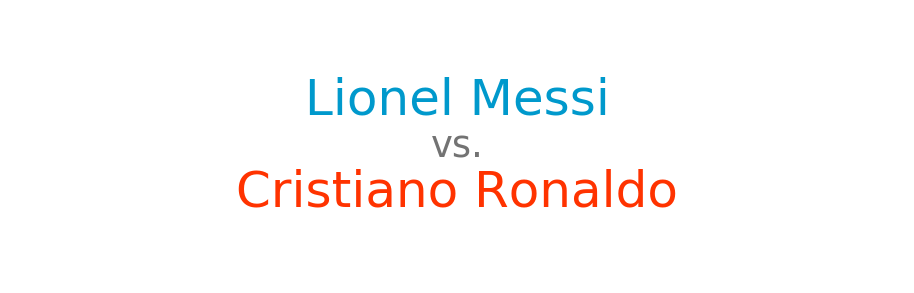

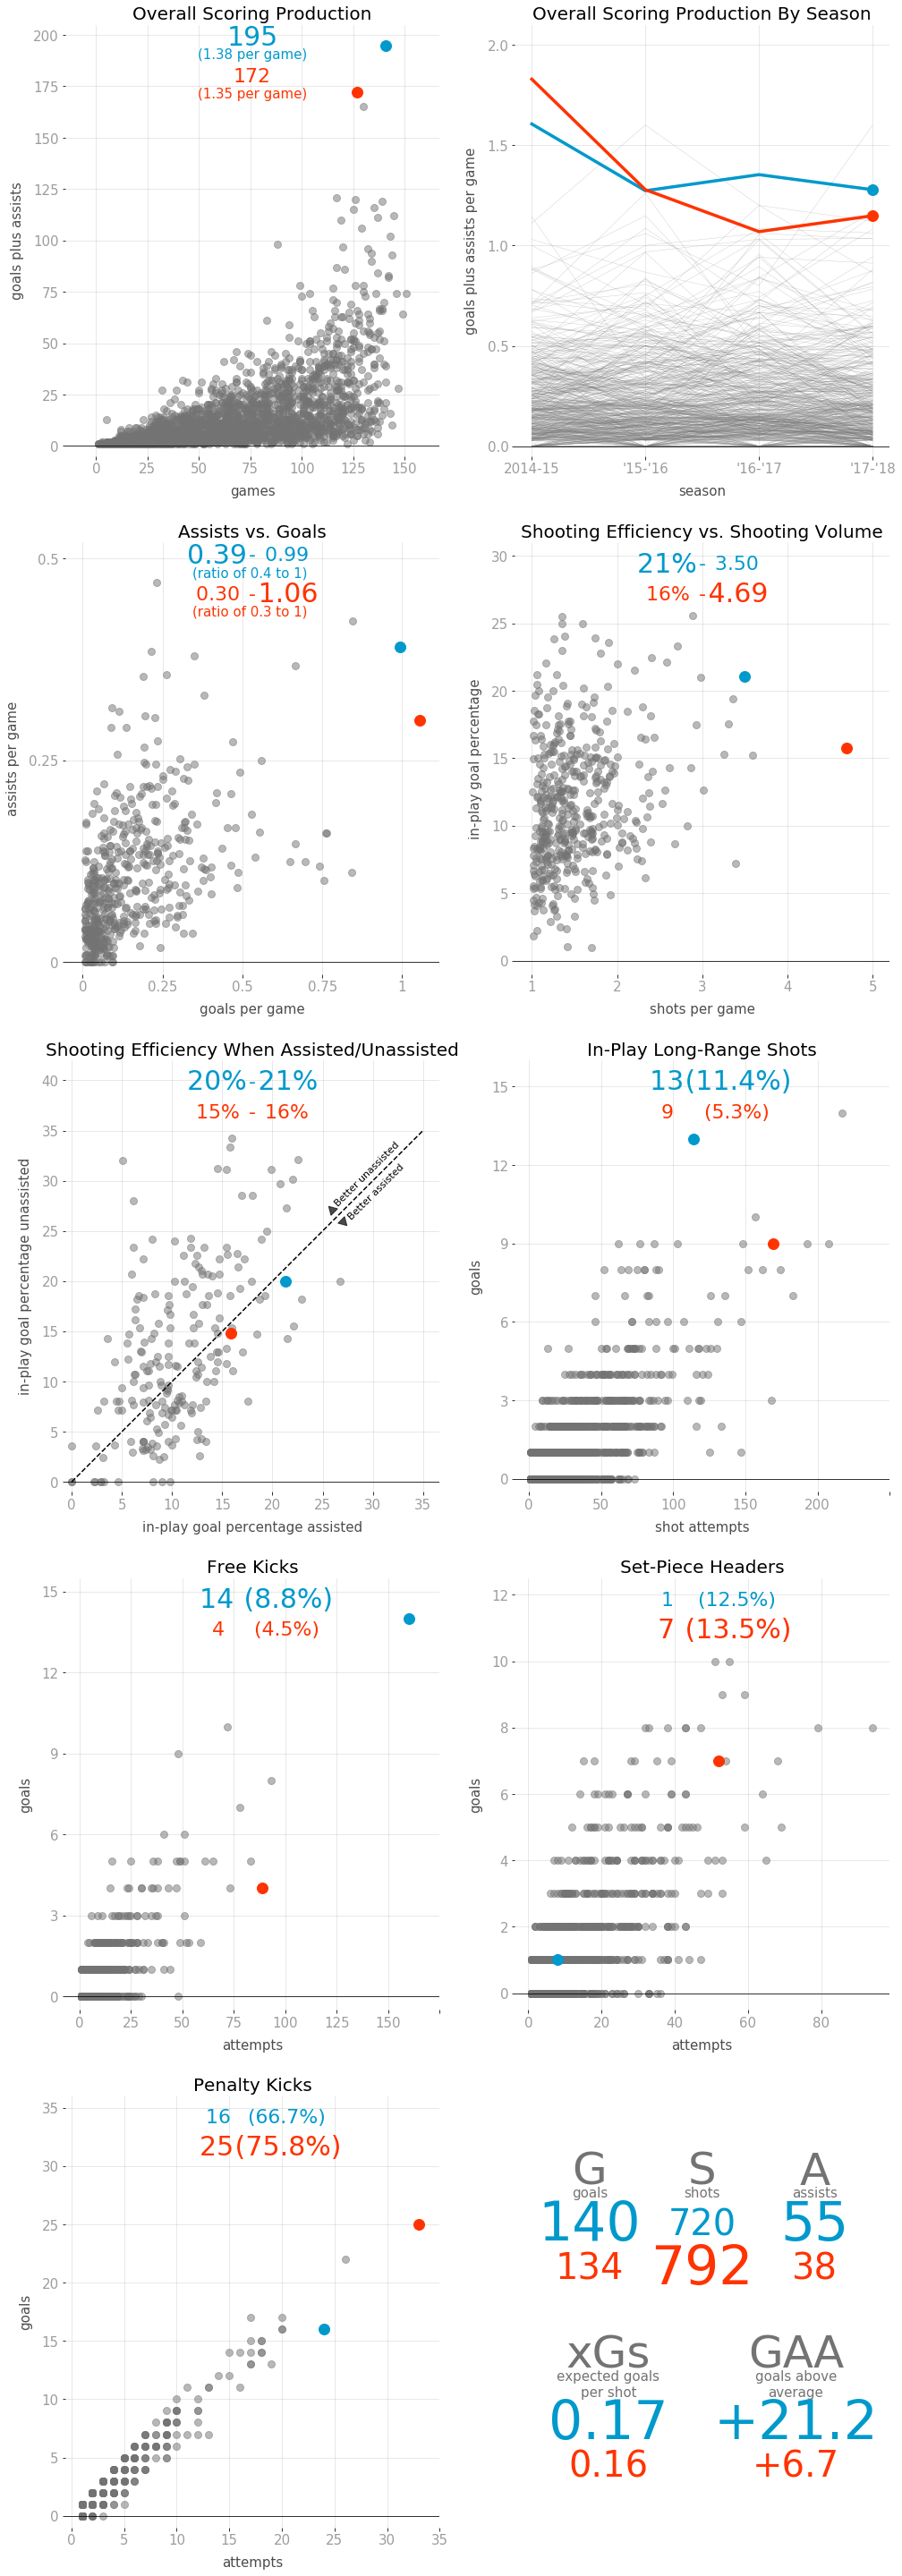

In [8]:
player1 = 'Lionel Messi'
player2 = 'Cristiano Ronaldo'


## player finder

names = sorted(names)
names_s = []
for n in names:
    names_s.append(n.split())

player1_ = input("Player1: ")
while True:
    while player1_ not in names:
        suggestions1 = []
        for ns in names_s:
            for s in ns:
                if (s in player1_ and len(s)>3):
                    suggestions1.append(names[names_s.index(ns)])
        print("player not found (suggestions: {})".format(str(suggestions1).replace("[","").replace("]","")))
        player1_ = input("Player1: ")

    for z in name:
        if name[z] == player1_:
            player1_id = z
    print("player found: {} ({})".format(player1_,teams[player1_id][list(teams[player1_id].keys())[0]]))
    player1 = player1_
    player1_ = input("Enter to confirm / Write another name to change :")
    if player1_ == "":
        break

player2_ = input("\nPlayer2: ")
while True:
    while player2_ not in names:
        suggestions2 = []
        for ns in names_s:
            for s in ns:
                if (s in player2_ and len(s)>3):
                    suggestions2.append(names[names_s.index(ns)])
        print("player not found (suggestions: {})".format(str(suggestions2).replace("[","").replace("]","")))
        player2_ = input("Player2: ")

    for z in name:
        if name[z] == player2_:
            player2_id = z
    print("player found: {} ({})".format(player2_,teams[player2_id][list(teams[player2_id].keys())[0]]))
    player2 = player2_
    player2_ = input("Enter to confirm / Write another name to change :")
    if player2_ == "":
        break
                
print("\n\n\n")



## plotting header

plt.figure(figsize=(16,5))
plt.annotate("{}".format(player1),(.5,.67),ha="center",va="center",size=50,color="#0099cc")
plt.annotate("vs.",(.5,.5),ha="center",va="center",size=37,color="#737373")
plt.annotate("{}".format(player2),(.5,.33),ha="center",va="center",size=50,color="#ff3300")
plt.xticks([])
plt.yticks([])
ax = plt.gca()
ax.set_facecolor("white")
plt.box(on=None)



## plotting statistics dashboard

plt.figure(figsize=(16,55.5))

### OVERALL PRODUCTION ###

plt.subplot(5,2,1)
plt.scatter(x1,y1,s=64,color="#737373",alpha=0.5)
for z in range(len(players1)):
    if name[players1[z]]==player1:
        rp = y1[z]/x1[z]
    if name[players1[z]]==player2:
        rp2 = y1[z]/x1[z]
for z in range(len(players1)):
    if name[players1[z]]==player1:
        plt.plot(x1[z],y1[z],"o",markersize=12,color="#0099cc",alpha=1)
        plt.annotate("{}".format(y1[z])
                     ,(.5,.97),xycoords="axes fraction",va="center",ha="center",size=30 if rp2<rp else 22,color="#0099cc")
        plt.annotate("({:.2f} per game)".format(y1[z]/x1[z])
                     ,(.5,.93),xycoords="axes fraction",va="center",ha="center",size=15,color="#0099cc")
    if name[players1[z]]==player2:
        plt.plot(x1[z],y1[z],"o",markersize=12,color="#ff3300",alpha=1)
        plt.annotate("{}".format(y1[z])
                     ,(.5,.88),xycoords="axes fraction",va="center",ha="center",size=30 if rp2>rp else 22,color="#ff3300")
        plt.annotate("({:.2f} per game)".format(y1[z]/x1[z])
                     ,(.5,.84),xycoords="axes fraction",va="center",ha="center",size=15,color="#ff3300")
plt.grid(color="#737373",alpha=0.2)
plt.axis('equal')
plt.xticks(range(0,160,25),size=15,alpha=0.7,color="#737373")
plt.yticks(range(0,210,25),size=15,alpha=0.7,color="#737373")
plt.xlabel("games",labelpad=10,size=15,alpha=0.7) # new
plt.ylabel("goals plus assists",labelpad=10,size=15,alpha=0.7) # new
plt.ylim(-5,205) # new
ax = plt.gca()
ax.set_facecolor("white")
ax.get_ygridlines()[0].set_alpha(1)
ax.get_ygridlines()[0].set_color("black")
plt.subplots_adjust(left=0.1,right =0.9,top=0.82,bottom=0.12)
plt.title("Overall Scoring Production",size=20)
plt.box(on=None)

### OVERALL PRODUCTION BY SEASON ###

plt.subplot(5,2,2)
for player in players2 :
    x2 = [2014,2015,2016,2017] 
    y2 = [(len(shots2[(shots2.player_id==player)&(shots2.season==season)])
          +len(shots2[(shots2.player_assisted==name[player])&(shots2.season==season)]))
          /games_season[player][season] for season in x2]
    #if y2[3] > 1:
    if name[player] in [player1,player2]:
        plt.plot(x2,y2,lw=3.5,color=("#0099cc" if name[player]==player1 else "#ff3300"))
        plt.plot(x2[3],y2[3],"o",markersize=12,color=("#0099cc" if name[player]==player1 else "#ff3300"))
    else :
        plt.plot(x2,y2,color="#737373",lw=.3,alpha=0.5)
plt.grid(color="#737373",alpha=0.2)
plt.xticks(range(2014,2018,1),["2014-15", "'15-'16", "'16-'17", "'17-'18"],size=15,alpha=0.7,color="#737373")
plt.yticks(np.arange(0,2.1,step=.5),["0.0","0.5","1.0","1.5","2.0"],size=15,alpha=0.7,color="#737373")
plt.xlabel("season",labelpad=10,size=15,alpha=0.7) # new
plt.ylabel("goals plus assists per game",labelpad=10,size=15,alpha=0.7) # new
plt.ylim(-0.05,2.1) # new
ax = plt.gca()
ax.set_facecolor("white")
ax.get_ygridlines()[0].set_alpha(1)
ax.get_ygridlines()[0].set_color("black")
plt.title("Overall Scoring Production By Season",size=20)
plt.box(on=None)

### ASSISTS VS GOALS ###

plt.subplot(5,2,3)
plt.scatter(x3,y3,s=64 ,color="#737373",alpha=0.5)
for z in range(len(players3)):
    if name[players3[z]]==player1:
        yp = y3[z]
        xp = x3[z] 
    if name[players3[z]]==player2:
        yp2 = y3[z]
        xp2 = x3[z] 
for z in range(len(players3)):
    if name[players3[z]]==player1:
        plt.plot(x3[z],y3[z],"o",markersize=12,color="#0099cc",alpha=1)
        plt.annotate("{:.2f} ".format(y3[z])
                     ,(.5,.97),xycoords="axes fraction",xytext=(-35,0),textcoords="offset points",va="center",ha="center",size=30 if yp2<yp else 22,color="#0099cc")
        plt.annotate("{}".format("-")
                     ,(.5,.97),xycoords="axes fraction",xytext=(0,0),textcoords="offset points",va="center",ha="center",size=22,color="#0099cc")
        plt.annotate(" {:.2f}".format(x3[z])
                     ,(.5,.97),xycoords="axes fraction",xytext=(35,0),textcoords="offset points",va="center",ha="center",size=30 if xp2<xp else 22,color="#0099cc")
        plt.annotate("(ratio of {:.1f} to 1) ".format(y3[z]/x3[z])
                     ,(.5,.93),xycoords="axes fraction",xytext=(0,0),textcoords="offset points",va="center",ha="center"
                     ,size=15,color="#0099cc")
    if name[players3[z]]==player2:
        plt.plot(x3[z],y3[z],"o",markersize=12,color="#ff3300",alpha=1)
        plt.annotate("{:.2f} ".format(y3[z])
                     ,(.5,.88),xycoords="axes fraction",xytext=(-35,0),textcoords="offset points",va="center",ha="center",size=30 if yp2>yp else 22,color="#ff3300")
        plt.annotate("{}".format("-")
                     ,(.5,.88),xycoords="axes fraction",xytext=(0,0),textcoords="offset points",va="center",ha="center",size=22,color="#ff3300")
        plt.annotate(" {:.2f}".format(x3[z])
                     ,(.5,.88),xycoords="axes fraction",xytext=(35,0),textcoords="offset points",va="center",ha="center",size=30 if xp2>xp else 22,color="#ff3300")
        plt.annotate("(ratio of {:.1f} to 1) ".format(y3[z]/x3[z])
                     ,(.5,.84),xycoords="axes fraction",xytext=(0,0),textcoords="offset points",va="center",ha="center"
                     ,size=15,color="#ff3300")
plt.grid(color="#737373",alpha=0.2)
plt.xticks(np.arange(0,1.25,step=.25),["0","0.25","0.5","0.75","1"],size=15,alpha=0.7,color="#737373")
plt.yticks(np.arange(0,.75,step=.25),["0","0.25","0.5"],size=15,alpha=0.7,color="#737373")
plt.xlabel("goals per game",labelpad=10,size=15,alpha=0.7) # new
plt.ylabel("assists per game",labelpad=10,size=15,alpha=0.7) # new
plt.ylim(-.015,.52)
ax = plt.gca()
ax.set_facecolor("white")
ax.get_ygridlines()[0].set_alpha(1)
ax.get_ygridlines()[0].set_color("black")
plt.title("Assists vs. Goals",size=20)
plt.box(on=None)

### SHOOTING EFFICIENCY VS SHOOTING VOLUME ###

plt.subplot(5,2,4)
plt.scatter(x4,y4,s=64 ,color="#737373",alpha=0.5)
for z in range(len(players4)):
    if name[players4[z]]==player1:
        yp = y4[z]
        xp = x4[z] 
    if name[players4[z]]==player2:
        yp2 = y4[z]
        xp2 = x4[z] 
for z in range(len(players4)):
    if name[players4[z]]==player1:
        plt.plot(x4[z],y4[z],"o",markersize=12,color="#0099cc",alpha=1)
        plt.annotate("{:.0f}% ".format(y4[z])
                     ,(.5,.95),xycoords="axes fraction",xytext=(-35,0),textcoords="offset points",va="center",ha="center",size=30 if yp2<yp else 22,color="#0099cc")
        plt.annotate("{}".format("-")
                     ,(.5,.95),xycoords="axes fraction",xytext=(0,0),textcoords="offset points",va="center",ha="center",size=22,color="#0099cc")
        plt.annotate(" {:.2f}".format(x4[z])
                     ,(.5,.95),xycoords="axes fraction",xytext=(35,0),textcoords="offset points",va="center",ha="center",size=30 if xp2<xp else 22,color="#0099cc")
    if name[players4[z]]==player2:
        plt.plot(x4[z],y4[z],"o",markersize=12,color="#ff3300",alpha=1)
        plt.annotate("{:.0f}% ".format(y4[z])
                     ,(.5,.88),xycoords="axes fraction",xytext=(-35,0),textcoords="offset points",va="center",ha="center",size=30 if yp2>yp else 22,color="#ff3300")
        plt.annotate("{}".format("-")
                     ,(.5,.88),xycoords="axes fraction",xytext=(0,0),textcoords="offset points",va="center",ha="center",size=22,color="#ff3300")
        plt.annotate(" {:.2f}".format(x4[z])
                     ,(.5,.88),xycoords="axes fraction",xytext=(35,0),textcoords="offset points",va="center",ha="center",size=30 if xp2>xp else 22,color="#ff3300")
plt.grid(color="#737373",alpha=0.2)
plt.xticks(range(1,6,1),["1","2","3","4","5"],size=15,alpha=0.7,color="#737373")
plt.yticks(range(0,35,5),["0","5","10","15","20","25","30"],size=15,alpha=0.7,color="#737373")
plt.xlabel("shots per game",labelpad=10,size=15,alpha=0.7) # new
plt.ylabel("in-play goal percentage",labelpad=10,size=15,alpha=0.7) # new
plt.xlim(0.8,5.2)
plt.ylim(-1,31)
ax = plt.gca()
ax.set_facecolor("white")
ax.get_ygridlines()[0].set_alpha(1)
ax.get_ygridlines()[0].set_color("black")
plt.title("Shooting Efficiency vs. Shooting Volume",size=20)
plt.box(on=None)

### SHOOTING EFFICIENCY WHEN ASSISTED/UNASSISTED ###

plt.subplot(5,2,5)
plt.scatter(x5,y5,s=64 ,color="#737373",alpha=0.5)
for z in range(len(players5)):
    if name[players5[z]]==player1:
        yp = y5[z]
        xp = x5[z] 
    if name[players5[z]]==player2:
        yp2 = y5[z]
        xp2 = x5[z] 
for z in range(len(players5)):
    if name[players5[z]]==player1:
        plt.plot(x5[z],y5[z],"o",markersize=12,color="#0099cc",alpha=1)
        plt.annotate("{:.0f}% ".format(y5[z])
                     ,(.5,.95),xycoords="axes fraction",xytext=(-35,0),textcoords="offset points",va="center",ha="center",size=30 if yp2<yp else 22,color="#0099cc")
        plt.annotate("{}".format("-")
                     ,(.5,.95),xycoords="axes fraction",xytext=(0,0),textcoords="offset points",va="center",ha="center",size=22,color="#0099cc")
        plt.annotate(" {:.0f}%".format(x5[z])
                     ,(.5,.95),xycoords="axes fraction",xytext=(35,0),textcoords="offset points",va="center",ha="center",size=30 if xp2<xp else 22,color="#0099cc")
    if name[players5[z]]==player2:
        plt.plot(x5[z],y5[z],"o",markersize=12,color="#ff3300",alpha=1)
        plt.annotate("{:.0f}% ".format(y5[z])
                     ,(.5,.88),xycoords="axes fraction",xytext=(-35,0),textcoords="offset points",va="center",ha="center",size=30 if yp2>yp else 22,color="#ff3300")
        plt.annotate("{}".format("-")
                     ,(.5,.88),xycoords="axes fraction",xytext=(0,0),textcoords="offset points",va="center",ha="center",size=22,color="#ff3300")
        plt.annotate(" {:.0f}%".format(x5[z])
                     ,(.5,.88),xycoords="axes fraction",xytext=(35,0),textcoords="offset points",va="center",ha="center",size=30 if xp2>xp else 22,color="#ff3300")
plt.plot([0,35],[0,35],"black",lw=1.5,ls="--")
plt.grid(color="#737373",alpha=0.2)
plt.axis('equal')
plt.xticks(range(0,40,5),["0","5","10","15","20","25","30","35"],size=15,alpha=0.7,color="#737373")
plt.yticks(range(0,45,5),["0","5","10","15","20","25","30","35","40"],size=15,alpha=0.7,color="#737373")
plt.xlabel("in-play goal percentage assisted",labelpad=10,size=15,alpha=0.7) # new
plt.ylabel("in-play goal percentage unassisted",labelpad=10,size=15,alpha=0.7) # new
plt.ylim(-1,42)
plt.xlim(-1,37)
ax = plt.gca()
ax.set_facecolor("white")
ax.get_ygridlines()[0].set_alpha(1)
ax.get_ygridlines()[0].set_color("black")
plt.text(27+.4,27-.4,"Better assisted",rotation=45,rotation_mode="anchor",va="top",size=11)
plt.text(27-.35,27+.35,"Better unassisted",rotation=45,rotation_mode="anchor",va="bottom",size=11)
plt.plot(26.5-.6,26.5+.6,marker=(3,0,45),color="k",alpha=0.7,markersize=12)
plt.plot(26.5+.5,26.5-.5,marker=(3,0,225),color="k",alpha=0.7,markersize=12)
plt.title("Shooting Efficiency When Assisted/Unassisted",size=20)
plt.box(on=None)

### IN-PLAY LONG-RANGE SHOTS ###

plt.subplot(5,2,6)
plt.scatter(x6,y6,s=64 ,color="#737373",alpha=0.5)
for z in range(len(players6)):
    if name[players6[z]]==player1:
        yp = y6[z]
        xp = x6[z]
        rp = yp/xp
    if name[players6[z]]==player2:
        yp2 = y6[z]
        xp2 = x6[z]
        rp2 = yp2/xp2
for z in range(len(players6)):
    if name[players6[z]]==player1:
        plt.plot(x6[z],y6[z],"o",markersize=12,color="#0099cc",alpha=1)
        plt.annotate("{:.0f} ".format(y6[z])
                     ,(.5,.95),xycoords="axes fraction",xytext=(-35,0),textcoords="offset points",va="center",ha="center",size=30 if yp2<yp else 22,color="#0099cc")
        plt.annotate(" ({:.1%})".format(y6[z]/x6[z])
                     ,(.5,.95),xycoords="axes fraction",xytext=(35,0),textcoords="offset points",va="center",ha="center",size=30 if rp2<rp else 22,color="#0099cc")
    if name[players6[z]]==player2:
        plt.plot(x6[z],y6[z],"o",markersize=12,color="#ff3300",alpha=1)
        plt.annotate("{:.0f} ".format(y6[z])
                     ,(.5,.88),xycoords="axes fraction",xytext=(-35,0),textcoords="offset points",va="center",ha="center",size=30 if yp2>yp else 22,color="#ff3300")
        plt.annotate(" ({:.1%})".format(rp2)
                     ,(.5,.88),xycoords="axes fraction",xytext=(35,0),textcoords="offset points",va="center",ha="center",size=30 if rp2>rp else 22,color="#ff3300")
plt.grid(color="#737373",alpha=0.2)
plt.xticks(range(0,251,50),["0","50","100","150","200"],size=15,alpha=.7,color="#737373")
plt.yticks(range(0,16,3),["0","3","6","9","12","15"],size=15,alpha=.7,color="#737373")
plt.xlabel("shot attempts",labelpad=10,size=15,alpha=0.7) # new
plt.ylabel("goals",labelpad=10,size=15,alpha=0.7) # new
plt.ylim(-.5,16)
ax = plt.gca()
ax.set_facecolor("white")
ax.get_ygridlines()[0].set_alpha(1)
ax.get_ygridlines()[0].set_color("black")
plt.title("In-Play Long-Range Shots",size=20)
plt.box(on=None)

### FREE KICKS ###

plt.subplot(5,2,7)
plt.scatter(x7,y7,s=64 ,color="#737373",alpha=0.5)
for z in range(len(players7)):
    if name[players7[z]]==player1:
        yp = y7[z]
        xp = x7[z]
        rp = yp/xp
    if name[players7[z]]==player2:
        yp2 = y7[z]
        xp2 = x7[z]
        rp2 = yp2/xp2
for z in range(len(players7)):
    if name[players7[z]]==player1:
        plt.plot(xp,yp,"o",markersize=12,color="#0099cc",alpha=1)
        plt.annotate("{:.0f} ".format(yp)
                     ,(.5,.95),xycoords="axes fraction",xytext=(-35,0),textcoords="offset points",va="center",ha="center",size=30 if yp2<yp else 22,color="#0099cc")
        plt.annotate(" ({:.1%})".format(rp)
                     ,(.5,.95),xycoords="axes fraction",xytext=(35,0),textcoords="offset points",va="center",ha="center",size=30 if rp2<rp else 22,color="#0099cc")
    if name[players7[z]]==player2:
        plt.plot(xp2,yp2,"o",markersize=12,color="#ff3300",alpha=1)
        plt.annotate("{:.0f} ".format(yp2)
                     ,(.5,.88),xycoords="axes fraction",xytext=(-35,0),textcoords="offset points",va="center",ha="center",size=30 if yp2>yp else 22,color="#ff3300")
        plt.annotate(" ({:.1%})".format(rp2)
                     ,(.5,.88),xycoords="axes fraction",xytext=(35,0),textcoords="offset points",va="center",ha="center",size=30 if rp2>rp else 22,color="#ff3300")
plt.grid(color="#737373",alpha=0.2)
plt.xticks(range(0,176,25),["0","25","50","75","100","125","150"],size=15,alpha=.7,color="#737373")
plt.yticks(range(0,16,3),["0","3","6","9","12","15"],size=15,alpha=.7,color="#737373")
plt.xlabel("attempts",labelpad=10,size=15,alpha=0.7) # new
plt.ylabel("goals",labelpad=10,size=15,alpha=0.7) # new
plt.ylim(-.5,15.5)
ax = plt.gca()
ax.set_facecolor("white")
ax.get_ygridlines()[0].set_alpha(1)
ax.get_ygridlines()[0].set_color("black")
plt.title("Free Kicks",size=20)
plt.box(on=None)

### SET-PIECE HEADERS ###

plt.subplot(5,2,8)
plt.scatter(x8,y8,s=64 ,color="#737373",alpha=0.5)
for z in range(len(players8)):
    if name[players8[z]]==player1:
        yp = y8[z]
        xp = x8[z]
        rp = yp/xp
    if name[players8[z]]==player2:
        yp2 = y8[z]
        xp2 = x8[z]
        rp2 = yp2/xp2
for z in range(len(players8)):
    if name[players8[z]]==player1:
        plt.plot(xp,yp,"o",markersize=12,color="#0099cc",alpha=1)
        plt.annotate("{:.0f} ".format(yp)
                     ,(.5,.95),xycoords="axes fraction",xytext=(-35,0),textcoords="offset points",va="center",ha="center",size=30 if yp2<yp else 22,color="#0099cc")
        plt.annotate(" ({:.1%})".format(rp)
                     ,(.5,.95),xycoords="axes fraction",xytext=(35,0),textcoords="offset points",va="center",ha="center",size=30 if rp2<rp else 22,color="#0099cc")
    if name[players8[z]]==player2:
        plt.plot(xp2,yp2,"o",markersize=12,color="#ff3300",alpha=1)
        plt.annotate("{:.0f} ".format(yp2)
                     ,(.5,.88),xycoords="axes fraction",xytext=(-35,0),textcoords="offset points",va="center",ha="center",size=30 if yp2>yp else 22,color="#ff3300")
        plt.annotate(" ({:.1%})".format(rp2)
                     ,(.5,.88),xycoords="axes fraction",xytext=(35,0),textcoords="offset points",va="center",ha="center",size=30 if rp2>rp else 22,color="#ff3300")
plt.grid(color="#737373",alpha=0.2)
plt.xticks(range(0,81,20),["0","20","40","60","80"],size=15,alpha=.7,color="#737373")
plt.yticks(range(0,13,2),["0","2","4","6","8","10","12"],size=15,alpha=.7,color="#737373")
plt.xlabel("attempts",labelpad=10,size=15,alpha=0.7) # new
plt.ylabel("goals",labelpad=10,size=15,alpha=0.7) # new
plt.ylim(-.5,12.5)
ax = plt.gca()
ax.set_facecolor("white")
ax.get_ygridlines()[0].set_alpha(1)
ax.get_ygridlines()[0].set_color("black")
plt.title("Set-Piece Headers",size=20)
plt.box(on=None)

### PENALTY KICKS ###

plt.subplot(5,2,9)
plt.scatter(x9,y9,s=64 ,color="#737373",alpha=0.5)
for z in range(len(players9)):
    if name[players9[z]]==player1:
        yp = y9[z]
        xp = x9[z]
        rp = yp/xp
    if name[players9[z]]==player2:
        yp2 = y9[z]
        xp2 = x9[z]
        rp2 = yp2/xp2
for z in range(len(players9)):
    if name[players9[z]]==player1:
        plt.plot(xp,yp,"o",markersize=12,color="#0099cc",alpha=1)
        plt.annotate("{:.0f} ".format(yp)
                     ,(.5,.95),xycoords="axes fraction",xytext=(-35,0),textcoords="offset points",va="center",ha="center",size=30 if yp2<yp else 22,color="#0099cc")
        plt.annotate(" ({:.1%})".format(rp)
                     ,(.5,.95),xycoords="axes fraction",xytext=(35,0),textcoords="offset points",va="center",ha="center",size=30 if rp2<rp else 22,color="#0099cc")
    if name[players9[z]]==player2:
        plt.plot(xp2,yp2,"o",markersize=12,color="#ff3300",alpha=1)
        plt.annotate("{:.0f} ".format(yp2)
                     ,(.5,.88),xycoords="axes fraction",xytext=(-35,0),textcoords="offset points",va="center",ha="center",size=30 if yp2>yp else 22,color="#ff3300")
        plt.annotate(" ({:.1%})".format(rp2)
                     ,(.5,.88),xycoords="axes fraction",xytext=(35,0),textcoords="offset points",va="center",ha="center",size=30 if rp2>rp else 22,color="#ff3300")
plt.grid(color="#737373",alpha=0.2)
plt.xticks(range(0,36,5),["0","5","10","15","20","25","30","35"],size=15,alpha=.7,color="#737373")
plt.yticks(range(0,41,5),["0","5","10","15","20","25","30","35"],size=15,alpha=.7,color="#737373")
plt.xlabel("attempts",labelpad=10,size=15,alpha=0.7) # new
plt.ylabel("goals",labelpad=10,size=15,alpha=0.7) # new
plt.ylim(-1,36)
ax = plt.gca()
ax.set_facecolor("white")
ax.get_ygridlines()[0].set_alpha(1)
ax.get_ygridlines()[0].set_color("black")
plt.title("Penalty Kicks",size=20)
plt.box(on=None)

### STATS ###

plt.subplot(5,2,10)

plt.annotate("G",(.20,.825),ha="center",va="center",size=50,color="#737373")
plt.annotate("A",(.80,.825),ha="center",va="center",size=50,color="#737373")
plt.annotate("S",(.50,.825),ha="center",va="center",size=50,color="#737373")
#plt.annotate("xG",(.20,.4),ha="center",va="center",size=50,color="#737373")
plt.annotate("xGs",(.25,.4),ha="center",va="center",size=50,color="#737373")
plt.annotate("GAA",(.75,.4),ha="center",va="center",size=50,color="#737373")
plt.annotate("goals",(.20,.79),ha="center",va="top",size=15,color="#737373")
plt.annotate("assists",(.80,.79),ha="center",va="top",size=15,color="#737373")
plt.annotate("shots",(.50,.79),ha="center",va="top",size=15,color="#737373")
#plt.annotate("expected\ngoals",(.20,.365),ha="center",va="top",size=15,color="#737373")
plt.annotate("expected goals\nper shot",(.25,.365),ha="center",va="top",size=15,color="#737373")
plt.annotate("goals above\naverage",(.75,.365),ha="center",va="top",size=15,color="#737373")

gp = len(shots10[(shots10.result=="Goal")&(shots10.player==player1)])
ap = len(shots10[(shots10.result=="Goal")&(shots10.player_assisted==player1)])
xgp = sum(shots10[(shots10.player==player1)].xG)
gaap = gp - xgp
sp = len(shots10[(shots10.player==player1)])
xgsp = sum(shots10[(shots10.player==player1)].xG)/sp

gp2 = len(shots10[(shots10.result=="Goal")&(shots10.player==player2)])
ap2 = len(shots10[(shots10.result=="Goal")&(shots10.player_assisted==player2)])
xgp2 = sum(shots10[(shots10.player==player2)].xG)
gaap2 = gp2 - xgp2
sp2 = len(shots10[(shots10.player==player2)])
xgsp2 = sum(shots10[(shots10.player==player2)].xG)/sp2

plt.annotate("{:.0f}".format(gp),(.20,.7),xycoords="axes fraction",xytext=(0,0),textcoords="offset points",va="center"
             ,ha="center",size=60 if gp2<gp else (50 if gp2==gp else 40),color="#0099cc")
plt.annotate("{:.0f}".format(ap),(.80,.7),xycoords="axes fraction",xytext=(0,0),textcoords="offset points",va="center"
             ,ha="center",size=60 if ap2<ap else (50 if ap2==ap else 40),color="#0099cc")
plt.annotate("{:.0f}".format(sp),(.50,.7),xycoords="axes fraction",xytext=(0,0),textcoords="offset points",va="center"
             ,ha="center",size=60 if sp2<sp else (50 if sp2==sp else 40),color="#0099cc")
#plt.annotate("{:.0f}".format(xgp),(.20,.24),xycoords="axes fraction",xytext=(0,0),textcoords="offset points",va="center"
#             ,ha="center",size=50,color="#0099cc")
plt.annotate("{:.2f}".format(xgsp),(.25,.24),xycoords="axes fraction",xytext=(0,0),textcoords="offset points",va="center"
             ,ha="center",size=60 if xgsp2<xgsp else (50 if xgsp2==xgsp else 40),color="#0099cc")
plt.annotate("{}{:.1f}".format("+" if gaap>=0 else "",gaap),(.75,.24),xycoords="axes fraction",xytext=(0,0),textcoords="offset points",va="center"
             ,ha="center",size=60 if gaap2<gaap else (50 if gaap2==gaap else 40),color="#0099cc")

plt.annotate("{:.0f}".format(gp2),(.20,.6),xycoords="axes fraction",xytext=(0,0),textcoords="offset points",va="center"
             ,ha="center",size=60 if gp2>gp else (50 if gp2==gp else 40),color="#ff3300")
plt.annotate("{:.0f}".format(ap2),(.80,.6),xycoords="axes fraction",xytext=(0,0),textcoords="offset points",va="center"
             ,ha="center",size=60 if ap2>ap else (50 if ap2==ap else 40),color="#ff3300")
plt.annotate("{:.0f}".format(sp2),(.50,.6),xycoords="axes fraction",xytext=(0,0),textcoords="offset points",va="center"
             ,ha="center",size=60 if sp2>sp else (50 if sp2==sp else 40),color="#ff3300")
#plt.annotate("{:.0f}".format(xgp2),(.20,.14),xycoords="axes fraction",xytext=(0,0),textcoords="offset points",va="center"
#             ,ha="center",size=50,color="#ff3300")
plt.annotate("{:.2f}".format(xgsp2),(.25,.14),xycoords="axes fraction",xytext=(0,0),textcoords="offset points",va="center"
             ,ha="center",size=60 if xgsp2>xgsp else (50 if xgsp2==xgsp else 40),color="#ff3300")
plt.annotate("{}{:.1f}".format("+" if gaap2>=0 else "",gaap2),(.75,.14),xycoords="axes fraction",xytext=(0,0),textcoords="offset points",va="center"
             ,ha="center",size=60 if gaap2>gaap else (50 if gaap2==gaap else 40),color="#ff3300")

plt.xticks([])
plt.yticks([])
ax = plt.gca()
ax.set_facecolor("white")
plt.box(on=None)

### ###
plt.show()